# Fine Tuning a BERT Model with the Hugging Face Library

In this notebook, we will fine tune a BERT model using the HuggingFace library. We will explore the following steps in conjunction with a NLP task. Our task is to cluster similar sentences together.

## Steps:

1. Install dependencies
2. Load the dataset - EDA
3. Tokenization - Different methods
4. Fine-tuning the model - BERT (Transformer)
5. Evaluation - Accuracy, Precision, Recall, F1 Score
6. Save the model

## Dataset

Sentiment analysis is a NLP task where the objective is to classify the affective nature of a given text. The dataset we will use is the IMDB dataset which consists of 50,000 movie reviews. The dataset is divided into 25,000 reviews for training and 25,000 reviews for testing. The sentiment of the reviews is binary, meaning a review can be positive or negative.

## References

- [Hugging Face](https://huggingface.co/)
- [BERT](https://arxiv.org/abs/1810.04805)
- [IMDB Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)
- [Transformers](https://huggingface.co/transformers/)
- [Fine Tuning BERT](https://huggingface.co/transformers/training.html)


## Install Dependencies

In [8]:
import transformers
import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random

## Dataset

In [45]:
## we will use the IMDB dataset from Huggingface

# load the dataset
dataset = datasets.load_dataset("imdb")


# examine the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [47]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [12]:
## Explore the dataset

train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['test'])
test_df = pd.DataFrame(dataset['test'])

# randomly sample 5 examples from the training set df
print(train_df.sample(5), '\n', val_df.sample(5), '\n', test_df.sample(5))

                                                    text  label
20100  Kurt Russell's chameleon-like performance, cou...      1
9770   ... and I have seen some bad ones.<br /><br />...      0
24981  For a first film in a proposed series it achie...      1
210    A decent sequel, but does not pack the punch o...      0
12779  11 Oscar nominations and zero win!!! Am yet to...      1 
                                                     text  label
17667  Bloody marvelous. Recommended by a friend who ...      1
18856  The consequences of love: There is really some...      1
22871  Out of the 600 or so Spaghetti Westerns made t...      1
15807  it's the best movie i have ever seen!!!!!! i j...      1
15108  Fast Times it ain't. But check this movie out,...      1 
                                                     text  label
9460   Go up to any film fan and ask them the title o...      0
11265  Brainy, cross-dressing little boy finds succes...      0
8936   Gritty drama? Emotionally pow

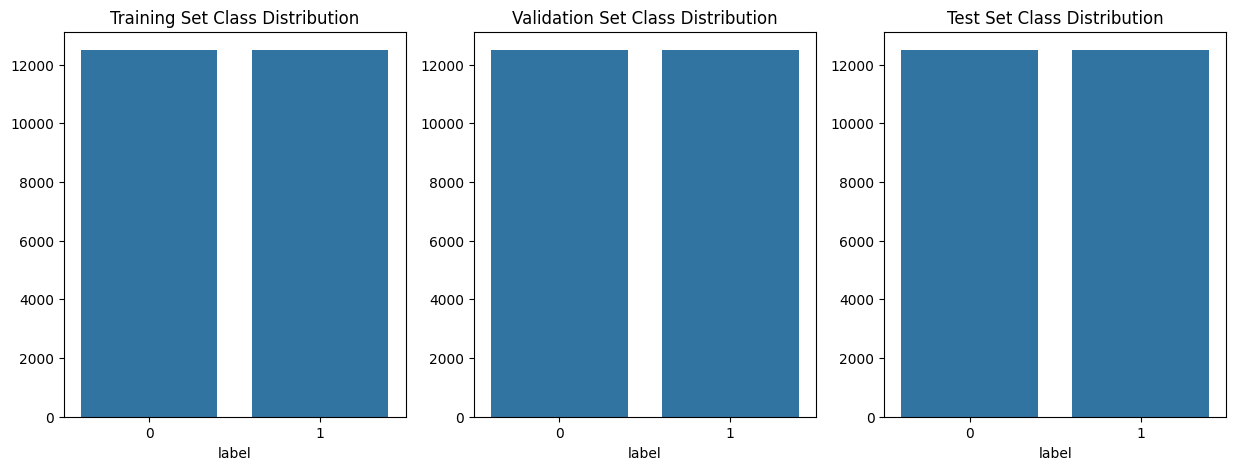

In [15]:
## Let's get a better sense of the data

# plot the class distributions
import matplotlib.pyplot as plt
import seaborn as sns

train_labels_count = train_df['label'].value_counts()
val_labels_count = val_df['label'].value_counts()
test_labels_count = test_df['label'].value_counts()


# plot the class distributions for the training set, validation set, and test set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x=train_labels_count.index, y=train_labels_count.values, ax=ax[0])
ax[0].set_title('Training Set Class Distribution')
sns.barplot(x=val_labels_count.index, y=val_labels_count.values, ax=ax[1])
ax[1].set_title('Validation Set Class Distribution')
sns.barplot(x=test_labels_count.index, y=test_labels_count.values, ax=ax[2])
ax[2].set_title('Test Set Class Distribution')
plt.show()

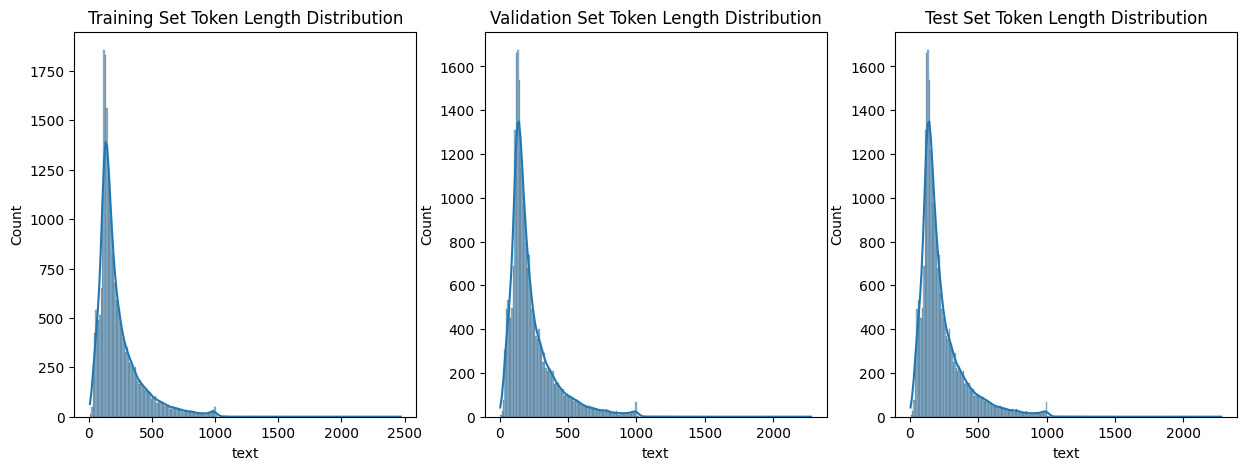

In [16]:
## Plot the token length distributions

train_token_lengths = train_df['text'].apply(lambda x: len(x.split()))
val_token_lengths = val_df['text'].apply(lambda x: len(x.split()))
test_token_lengths = test_df['text'].apply(lambda x: len(x.split()))

# plot the token length distributions for the training set, validation set, and test set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(train_token_lengths, ax=ax[0], kde=True)
ax[0].set_title('Training Set Token Length Distribution')
sns.histplot(val_token_lengths, ax=ax[1], kde=True)
ax[1].set_title('Validation Set Token Length Distribution')
sns.histplot(test_token_lengths, ax=ax[2], kde=True)
ax[2].set_title('Test Set Token Length Distribution')
plt.show()

In [17]:
## TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# fit the vectorizer on the training set
tfidf_vectorizer.fit(train_df['text'])

# transform the training, validation, and test sets
X_train_tfidf = tfidf_vectorizer.transform(train_df['text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['text'])

# convert the labels to tensors
y_train = torch.tensor(train_df['label'])
y_val = torch.tensor(val_df['label'])
y_test = torch.tensor(test_df['label'])

# create a dataframe of the TF-IDF vectors
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_val_tfidf_df = pd.DataFrame(X_val_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# print the first few rows of the TF-IDF vectors
print(X_train_tfidf_df.head())

    00  000        10  100   11   12   13  13th   14   15  ...     young  \
0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.043502   
1  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.000000   
2  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.000000   
3  0.0  0.0  0.084063  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.000000   
4  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.047706   

   younger  your  yourself  youth  zero  zizek  zombie  zombies  zone  
0      0.0   0.0       0.0    0.0   0.0    0.0     0.0      0.0   0.0  
1      0.0   0.0       0.0    0.0   0.0    0.0     0.0      0.0   0.0  
2      0.0   0.0       0.0    0.0   0.0    0.0     0.0      0.0   0.0  
3      0.0   0.0       0.0    0.0   0.0    0.0     0.0      0.0   0.0  
4      0.0   0.0       0.0    0.0   0.0    0.0     0.0      0.0   0.0  

[5 rows x 5000 columns]


In [19]:
## Top 10 most important words for each class

# get the top 10 most important words for each class
top_10_positive_words = np.argsort(tfidf_vectorizer.idf_)[-10:]
top_10_negative_words = np.argsort(tfidf_vectorizer.idf_)[:10]

# print the top 10 most important words for each class
print('Top 10 Most Important Words for Positive Class:')
for idx in top_10_positive_words:
    print(tfidf_vectorizer.get_feature_names_out()[idx])
    
print('\nTop 10 Most Important Words for Negative Class:')
for idx in top_10_negative_words:
    print(tfidf_vectorizer.get_feature_names_out()[idx])

Top 10 Most Important Words for Positive Class:
gadget
timon
fido
rukh
antwone
gundam
biko
carla
zizek
macarthur

Top 10 Most Important Words for Negative Class:
the
and
of
to
this
is
it
in
that
but


## Explore Tokenization

- [Tokenization](https://huggingface.co/transformers/tokenizer_summary.html)

### Character based tokenizers

Character based tokenizers are not often used due as the model to learn semantic represenations of words. They can, however, be useful in the right contexts. For example, implementing weights for characters to create labeled datasets.

In [30]:
text = """
he Senate faces a tough choice on Ukraine aid as Speaker Mike Johnson (R-La.) says the House will move a Ukraine package after the April recess, but one that could be strikingly different from the $95 billion package the upper chamber passed in February.

The Speaker has already told Republican senators that a substantial portion of the assistance in the House bill would be provided in the form of a loan, an idea championed by former President Trump but initially dismissed by Senate leaders in both parties.

Johnson has signaled the House will take action on a Ukraine assistance bill in the next few weeks but hasn’t shared many details about what the package will look like.
"""

# Tokenize the text into characters
def char_tokenizer(text: str) -> list:
    return list(text)

# Convert the characters back into text
tokens = char_tokenizer(text)

# train a word2vec model on the characters
import gensim
from gensim.models import Word2Vec

# train a word2vec model on the characters
char_model = Word2Vec(sentences=[char_tokenizer(text)],
                      vector_size=100,
                      epochs=100,
                      window=5,
                      min_count=1,
                      sg=0
                      )

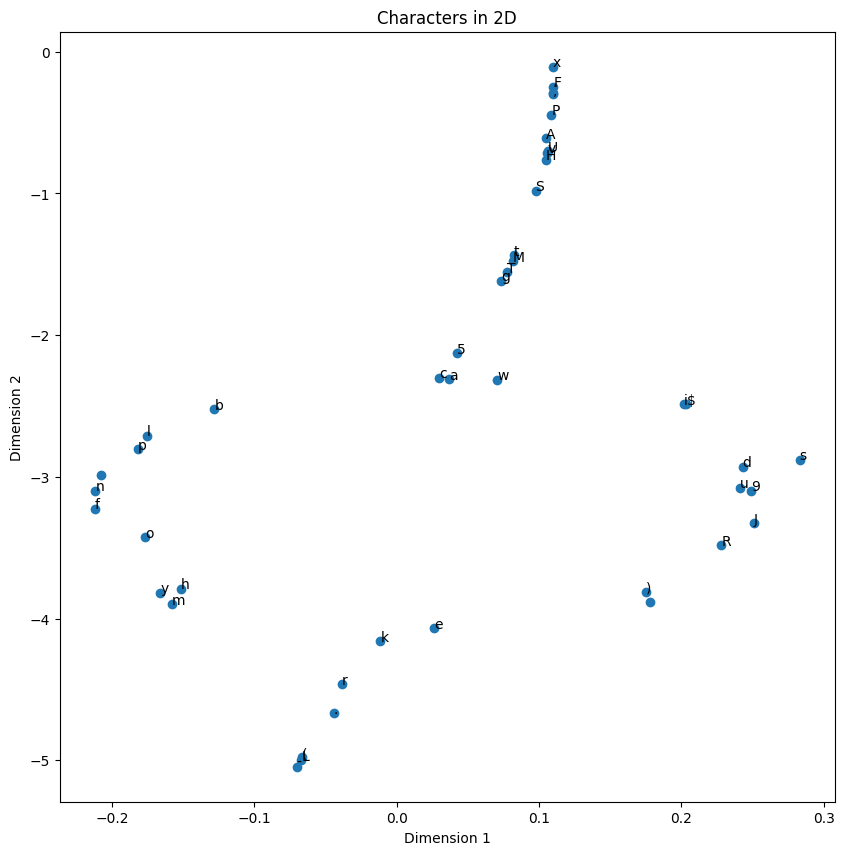

In [29]:
# plot the characters in the word2vec model
from sklearn.manifold import TSNE

# get the character vectors
char_vectors = char_model.wv[char_model.wv.key_to_index]

# reduce the dimensionality of the character vectors
tsne = TSNE(n_components=2, random_state=0)
char_vectors_2d = tsne.fit_transform(char_vectors)

# plot the characters in 2D
plt.figure(figsize=(10, 10))
plt.scatter(char_vectors_2d[:, 0], char_vectors_2d[:, 1])
for char, (x, y) in zip(char_model.wv.key_to_index, char_vectors_2d):
    plt.text(x, y, char)
plt.title('Characters in 2D')
# add the x, y axis labels
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Subword tokenizers

Subword tokenizers are optimized on the assumption that frequently used words should be tokenized as a single unit, and less frequently used words are tokenized into subwords.

In [34]:
## huggingface subword tokenizer example on our text
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
tokens = tokenizer.tokenize(text)

# check for split tokens and print it and the previous token
for i, token in enumerate(tokens):
    if '##' in token:
        print(tokens[i-1], token)

striking ##ly


### Byte-Pair Encoding (BPE)

Byte-Pair Encoding is a subword tokenization algorithm that iteratively replaces the most frequent pair of bytes in a sequence with a new byte. This process is repeated until the desired vocabulary size is reached.

- Sennrich, Rico, et al. Neural Machine Translation of Rare Words with Subword Units. arXiv:1508.07909, arXiv, 10 June 2016. arXiv.org, https://doi.org/10.48550/arXiv.1508.07909.
- [BPE](https://huggingface.co/transformers/tokenizer_summary.html#byte-pair-encoding-bpe)
- Andrej Karpath's lecture on OpenAI's GPT tokenizer [video](https://www.youtube.com/watch?v=zduSFxRajkE&t=2527s&ab_channel=AndrejKarpathy)

### WordPiece

WordPiece is a subword tokenization algorithm used in the Bert model. WordPiece does not rely on the frequency of the words in the dataset. Instead, it maximizes the likelihood of the training data.

In [37]:
# how can tell you the huggingface tokenizer is a subword tokenizer

tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')

# print the tokenizer information
print(type(tokenizer).__name__)

BertTokenizer


In [38]:
# use dir to get the attributes and methods of the tokenizer
token_attrs = dir(tokenizer)
for attr in token_attrs:
    if not attr.startswith('_'):
        print(attr)

SPECIAL_TOKENS_ATTRIBUTES
add_special_tokens
add_tokens
added_tokens_decoder
added_tokens_encoder
additional_special_tokens
additional_special_tokens_ids
all_special_ids
all_special_tokens
all_special_tokens_extended
apply_chat_template
as_target_tokenizer
basic_tokenizer
batch_decode
batch_encode_plus
bos_token
bos_token_id
build_inputs_with_special_tokens
chat_template
clean_up_tokenization
clean_up_tokenization_spaces
cls_token
cls_token_id
convert_added_tokens
convert_ids_to_tokens
convert_tokens_to_ids
convert_tokens_to_string
create_token_type_ids_from_sequences
decode
default_chat_template
deprecation_warnings
do_basic_tokenize
do_lower_case
encode
encode_plus
eos_token
eos_token_id
from_pretrained
get_added_vocab
get_special_tokens_mask
get_vocab
ids_to_tokens
init_inputs
init_kwargs
is_fast
mask_token
mask_token_id
max_len_sentences_pair
max_len_single_sentence
max_model_input_sizes
model_input_names
model_max_length
name_or_path
num_special_tokens_to_add
pad
pad_token
pad_tok

### Unigram

Unigram trims down the vocabulary size during the training process by defining a log loss function that is minimized during training. During the training process, the model computes the overall loss would increase if the token was removed from the vocabulary. Huggingface models do not directly use Unigram, but the Unigram tokenizer can be used in conjunction with SentencePiece.

- [Unigram](https://huggingface.co/transformers/tokenizer_summary.html#unigram)
- [SentencePiece](https://huggingface.co/transformers/tokenizer_summary.html#sentencepiece)
- Kudo, Taku. Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates. arXiv:1804.10959, arXiv, 29 Apr. 2018. arXiv.org, http://arxiv.org/abs/1804.10959.

### SentencePiece

Some languages do not use spaces to demarcate lexical units. SentencePiece can be used for langauge specific tokenization. Text is an input stream and uses BPE or Unigram to tokenize the text, i.e., create the vocabulary of the model.

In [40]:
# XLNetTokenizer
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained('xlnet/xlnet-base-cased')
tokens = tokenizer.tokenize(text)

# check for split tokens and print it and the previous token
for i, token in enumerate(tokens):
    if '▁' in token:
        print(tokens[i-1], token)

ImportError: 
XLNetTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


## Naive Bayes Model

Let's establish a baseline model using the Naive Bayes algorithm. We will use the CountVectorizer to convert the text data into a matrix of token counts. We will then use the MultinomialNB model to classify the sentiment of the reviews.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

# initialize the count vectorizer
count_vectorizer = CountVectorizer(max_features=5000)

# fit the vectorizer on the training set
count_vectorizer.fit(train_df['text'])

# train a naive bayes classifier on the count vectors
from sklearn.naive_bayes import MultinomialNB

# transform the training, validation, and test sets
X_train_count = count_vectorizer.transform(train_df['text'])
X_val_count = count_vectorizer.transform(val_df['text'])
X_test_count = count_vectorizer.transform(test_df['text'])

# train a naive bayes classifier on the count vectors
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_count, y_train)

# evaluate the classifier on the validation set
from sklearn.metrics import accuracy_score

# make predictions on the validation set
y_val_pred = nb_classifier.predict(X_val_count)

# calculate the accuracy of the classifier
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.8235


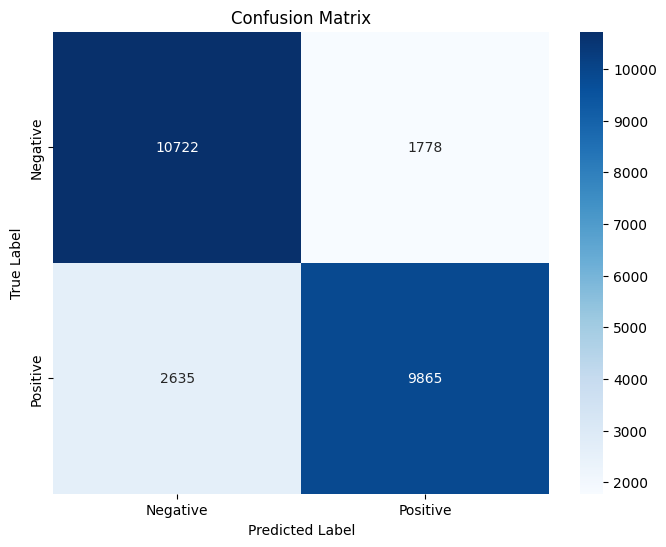

In [43]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Fine Tuning BERT

Fine tuning is the process of using the pre-trained model and training it on a new dataset. The pre-trained model has learned weights of its training dataset, and fine tuning strengthens the weights on the new dataset.

- [Fine Tuning BERT](https://huggingface.co/transformers/training.html)
- Howard, Jeremy, and Sebastian Ruder. Universal Language Model Fine-Tuning for Text Classification. arXiv:1801.06146, arXiv, 23 May 2018. arXiv.org, https://doi.org/10.48550/arXiv.1801.06146.

### Preprocessing

In [48]:
check_point = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(check_point)

In [60]:
# tokenize our text
tokenized_sentences_ex = tokenizer(dataset['train']['text'][:5])

# examine the tokenized sentences
for sentence in tokenized_sentences_ex:
    print(sentence)

input_ids
token_type_ids
attention_mask


In [61]:
tokenizer.convert_ids_to_tokens(tokenized_sentences_ex['input_ids'][0])

['[CLS]',
 'i',
 'rented',
 'i',
 'am',
 'curious',
 '-',
 'yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.',
 'i',
 'also',
 'heard',
 'that',
 'at',
 'first',
 'it',
 'was',
 'seized',
 'by',
 'u',
 '.',
 's',
 '.',
 'customs',
 'if',
 'it',
 'ever',
 'tried',
 'to',
 'enter',
 'this',
 'country',
 ',',
 'therefore',
 'being',
 'a',
 'fan',
 'of',
 'films',
 'considered',
 '"',
 'controversial',
 '"',
 'i',
 'really',
 'had',
 'to',
 'see',
 'this',
 'for',
 'myself',
 '.',
 '<',
 'br',
 '/',
 '>',
 '<',
 'br',
 '/',
 '>',
 'the',
 'plot',
 'is',
 'centered',
 'around',
 'a',
 'young',
 'swedish',
 'drama',
 'student',
 'named',
 'lena',
 'who',
 'wants',
 'to',
 'learn',
 'everything',
 'she',
 'can',
 'about',
 'life',
 '.',
 'in',
 'particular',
 'she',
 'wants',
 'to',
 'focus',
 'her',
 'attention',
 '##s',
 'to',
 'making',
 'some',
 

In [63]:
# tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

# tokenize the imdb dataset
tokenized_imdb = dataset.map(tokenize, batched=True)


Map: 100%|██████████| 50000/50000 [01:27<00:00, 574.36 examples/s]


### Padding

In [74]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# initialize data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [75]:
# adjust our dataset
tokenized_imdb = tokenized_imdb.remove_columns(['text'])
tokenized_imdb = tokenized_imdb.rename_column('label', 'labels')
tokenized_imdb.set_format('torch')
tokenized_imdb['train'].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

### Data loaders

In [76]:
from torch.utils.data import DataLoader

train_dl = DataLoader(tokenized_imdb['train'], batch_size=8, shuffle=True, collate_fn=data_collator)

eval_dl = DataLoader(tokenized_imdb['test'], batch_size=8, collate_fn=data_collator)

In [77]:
for batch in train_dl:
    print(batch)
    break

{'labels': tensor([0, 0, 1, 0, 0, 1, 1, 0]), 'input_ids': tensor([[  101,  2065,  2017,  ...,     0,     0,     0],
        [  101,  2023,  3185,  ...,     0,     0,     0],
        [  101,  2023, 17743,  ...,     0,     0,     0],
        ...,
        [  101,  4406,  2178,  ...,     0,     0,     0],
        [  101,  4166, 28697,  ...,     0,     0,     0],
        [  101,  2888, 16183,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


### Training

In [79]:
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler
import torch

from tqdm.auto import tqdm

model = BertForSequenceClassification.from_pretrained(check_point, num_labels=2)
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
print(num_training_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


9375


/home/james/miniconda3/envs/fed_papers/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cuda')

In [81]:
from tqdm.auto import tqdm
Progress_bar = tqdm(range(num_training_steps), desc='Training')

model.train()

for epoch in range(num_epochs):
    for batch in train_dl:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        Progress_bar.update(1)

Training: 100%|██████████| 9375/9375 [29:33<00:00,  4.97it/s]

In [89]:
# evaluate the model
import evaluate #!pip install evaluate

metric = evaluate.load('accuracy', 'glue')
model.eval()
for batch in eval_dl:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    metric.add_batch(predictions=predictions, references=labels)
    
metric.compute()

{'accuracy': 0.90704}

[Clustering](https://colab.research.google.com/drive/11QXlaWqaKEj9MjVMGkhMLXwQYLDH9h-H#scrollTo=6FtQA8MArVSq)